# Competition Documentation

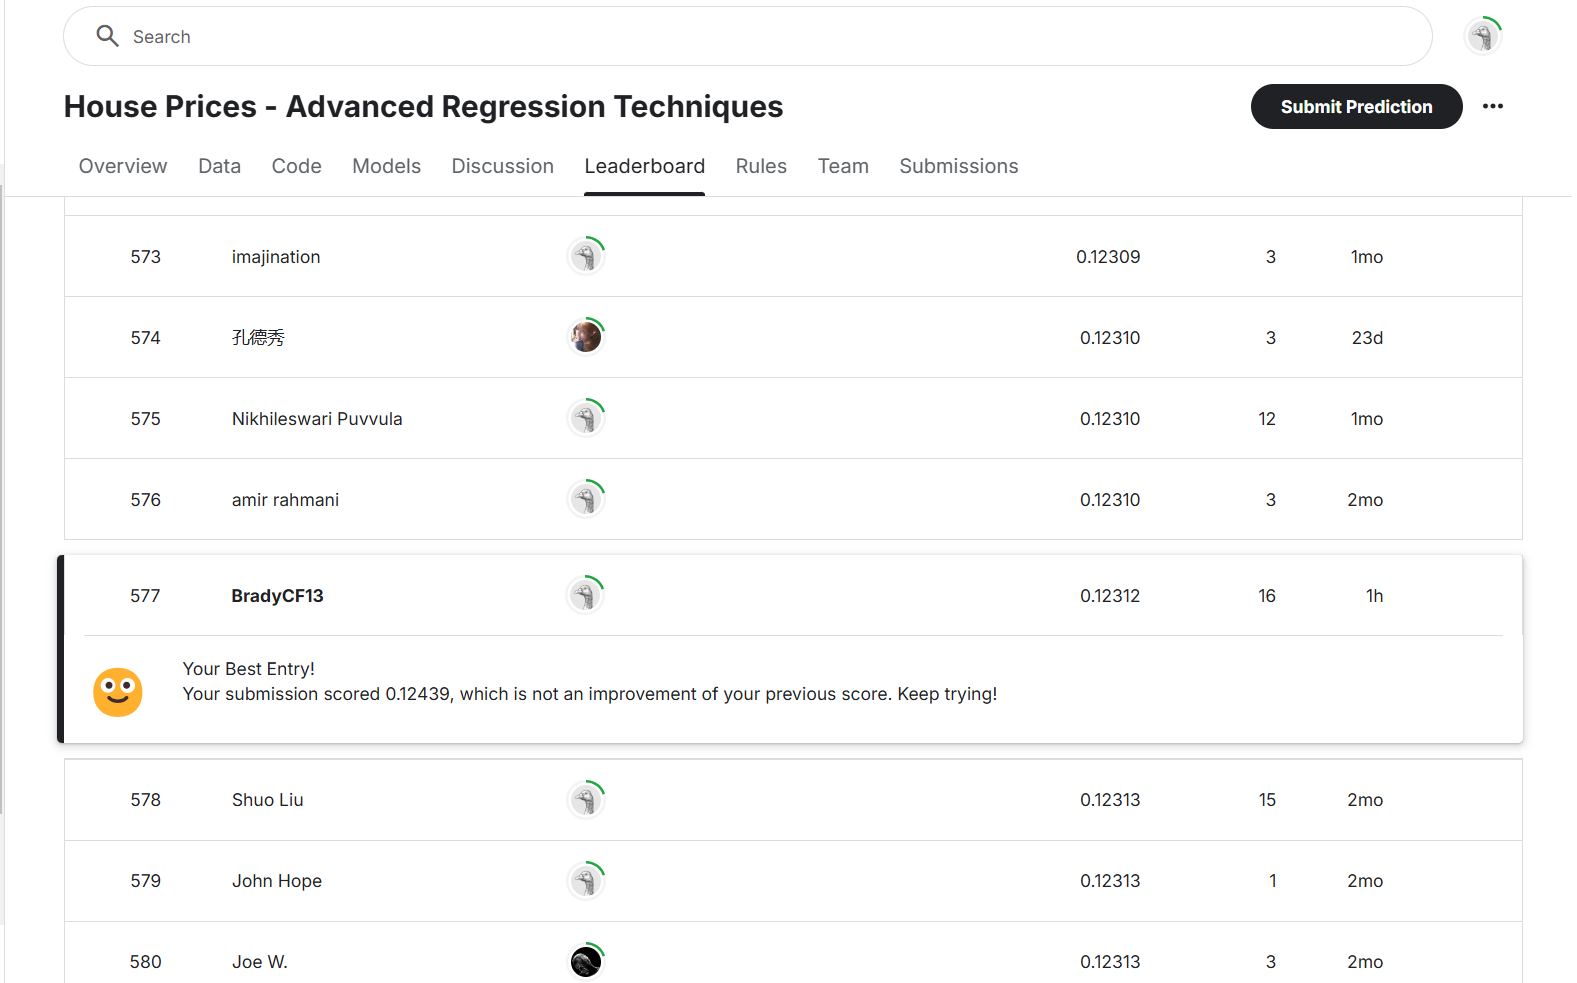

# Project Code

In [ ]:
pip install catboost

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.experimental import enable_iterative_imputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import IterativeImputer
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostRegressor
from sklearn.linear_model import LinearRegression

# Load the training and testing datasets
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [ ]:
# Explore the data
# Print basic information about the training dataset
# Display basic information about the training dataset
print("Basic information of the training data:")
print(train.info())

# Show the first five rows of the training dataset
print("\nFirst five rows of the training data:")
print(train.head())

# Display summary statistics for numerical columns
print("\nSummary statistics of the training data:")
print(train.describe())

Basic information of the training data:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual 

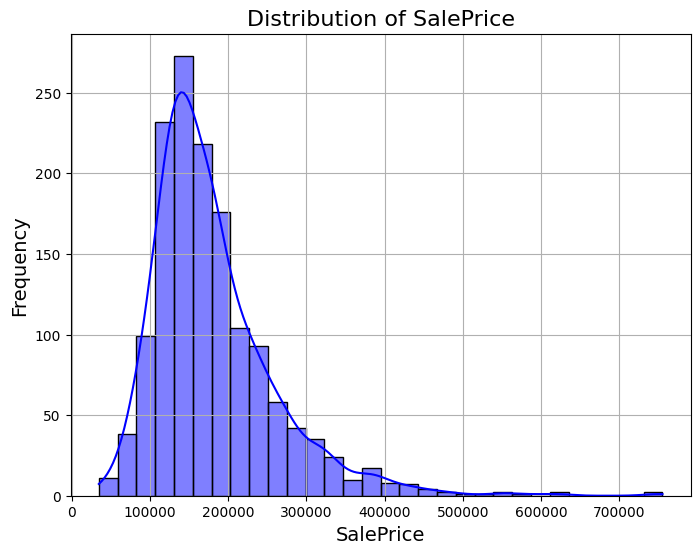

In [ ]:
# Plot the distribution of the target variable
plt.figure(figsize=(8, 6))
sns.histplot(train['SalePrice'], kde=True, bins=30, color='blue')
plt.title('Distribution of SalePrice', fontsize=16)
plt.xlabel('SalePrice', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.grid(True)
plt.show()

In [ ]:
# 1. Data Preprocessing
# Drop 'Id' for both train and test
train = train.drop(columns=['Id'])
test_ids = test['Id']  # Save test IDs for final output
test = test.drop(columns=['Id'])

# Separate target variable (SalePrice) from train
y_train_data = np.log(train['SalePrice'])  # Apply log transformation to SalePrice
X_train_data = train.drop(columns=['SalePrice'])

# Combine train and test datasets for consistent preprocessing
combined = pd.concat([X_train_data, test], axis=0)

In [ ]:
# Handle missing values
num_cols = combined.select_dtypes(include=['int64', 'float64']).columns
combined[num_cols] = combined[num_cols].fillna(combined[num_cols].median())

cat_cols = combined.select_dtypes(include=['object']).columns
combined[cat_cols] = combined[cat_cols].fillna('None')

In [ ]:
# Encode categorical variables
label_encoders = {}
for col in cat_cols:
    le = LabelEncoder()
    combined[col] = le.fit_transform(combined[col])
    label_encoders[col] = le

In [ ]:
# Linear Regression Without Feature Engineering
# Split combined data back into train and test
X_train_data = combined.iloc[:len(y_train_data), :]
X_test_data = combined.iloc[len(y_train_data):, :]

# Normalize numerical features
scaler = MinMaxScaler()
X_train_data = scaler.fit_transform(X_train_data)
X_test_data = scaler.transform(X_test_data)

X_train, X_val, y_train, y_val = train_test_split(X_train_data, y_train_data, test_size=0.2, random_state=42)

# 2. Train the Model
model = LinearRegression()
model.fit(X_train, y_train)

# 3. Train and Validation RMSE and R Squared values

# Calculate RMSE (Root Mean Squared Error) and R-squared on training data
rmse_train = np.sqrt(mean_squared_error(y_train, model.predict(X_train)))
r2_train = r2_score(y_train, model.predict(X_train))
print(f"Root Mean Squared Error (RMSE) on training set: {rmse_train}")
print(f"R-squared on training set: {r2_train}")

# Calculate RMSE (Root Mean Squared Error) and R-squared on validation data
rmse_val = np.sqrt(mean_squared_error(y_val, model.predict(X_val)))
r2_val = r2_score(y_val, model.predict(X_val))
print(f"Root Mean Squared Error (RMSE) on validation set: {rmse_val}")
print(f"R-squared on validation set: {r2_val}")

Root Mean Squared Error (RMSE) on training set: 0.1324231351979655
R-squared on training set: 0.8849686306534834
Root Mean Squared Error (RMSE) on validation set: 0.15900928086348315
R-squared on validation set: 0.8645116836223237


In [ ]:
# Feature Engineering
combined['TotalSF'] = combined['TotalBsmtSF'] + combined['1stFlrSF'] + combined['2ndFlrSF']
combined['HouseAge'] = combined['YrSold'] - combined['YearBuilt']
combined['HasPool'] = (combined['PoolArea'] > 0).astype(int)
combined['Qual_TotalSF'] = combined['OverallQual'] * combined['TotalSF']
combined['TotalBath'] = combined['FullBath'] + combined['HalfBath']
combined['RemodelAge'] = combined['YrSold'] - combined['YearRemodAdd']

In [ ]:
# CatBoostRegressor Model with Feature Engineering
# Split combined data back into train and test
X_train_data = combined.iloc[:len(y_train_data), :]
X_test_data = combined.iloc[len(y_train_data):, :]

# Normalize numerical features
scaler = MinMaxScaler()
X_train_data = scaler.fit_transform(X_train_data)
X_test_data = scaler.transform(X_test_data)

X_train, X_val, y_train, y_val = train_test_split(X_train_data, y_train_data, test_size=0.2, random_state=42)

# 2. Train the Model
model = CatBoostRegressor(n_estimators=2000, learning_rate=0.01, depth=5, verbose=0)
model.fit(X_train, y_train)

# 3. Train and Validation RMSE and R Squared values

# Calculate RMSE (Root Mean Squared Error) and R-squared on training data
rmse_train = np.sqrt(mean_squared_error(y_train, model.predict(X_train)))
r2_train = r2_score(y_train, model.predict(X_train))
print(f"Root Mean Squared Error (RMSE) on training set: {rmse_train}")
print(f"R-squared on training set: {r2_train}")

# Calculate RMSE (Root Mean Squared Error) and R-squared on validation data
rmse_val = np.sqrt(mean_squared_error(y_val, model.predict(X_val)))
r2_val = r2_score(y_val, model.predict(X_val))
print(f"Root Mean Squared Error (RMSE) on validation set: {rmse_val}")
print(f"R-squared on validation set: {r2_val}")

Root Mean Squared Error (RMSE) on training set: 0.0666859482453929
R-squared on training set: 0.9708286035130709
Root Mean Squared Error (RMSE) on validation set: 0.12887812613611158
R-squared on validation set: 0.9109948113496711



Top 10 Features by Importance:
         Feature  Importance
82  Qual_TotalSF   30.690400
79       TotalSF    9.742399
16   OverallQual    6.607563
45     GrLivArea    2.954901
60    GarageCars    2.785310
3        LotArea    2.722755
17   OverallCond    2.468331
40    CentralAir    2.434551
84    RemodelAge    2.423676
55    Fireplaces    2.036997


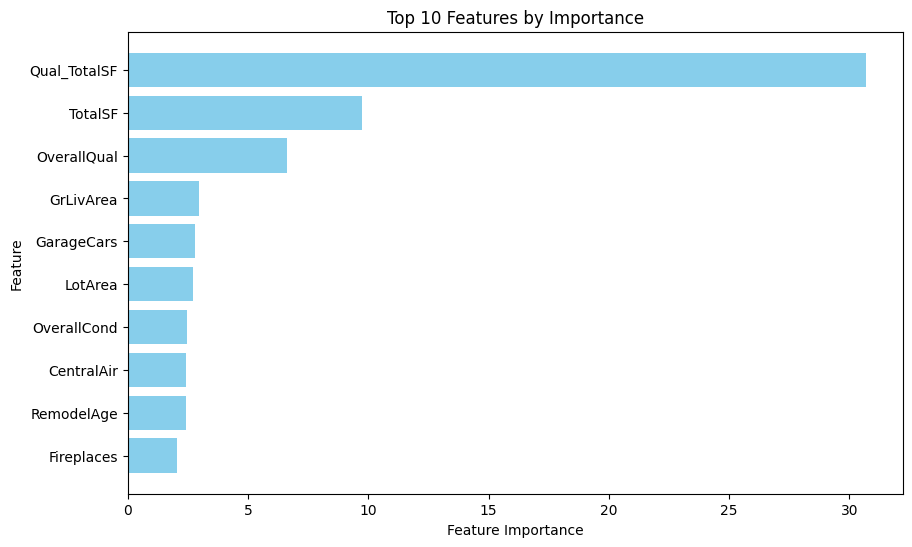

In [ ]:
# Feature Importance
feature_importances = model.get_feature_importance()
feature_names = combined.columns

# Combine feature names and importances into a DataFrame
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
})

# Sort by importance and get the top 10 features
top_features = feature_importance_df.sort_values(by='Importance', ascending=False).head(10)
print("\nTop 10 Features by Importance:")
print(top_features)

# Optional: Plot feature importance
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.barh(top_features['Feature'], top_features['Importance'], color='skyblue')
plt.gca().invert_yaxis()
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Top 10 Features by Importance')
plt.show()

In [ ]:
# Train on all of data rather than subset for train/validation
model.fit(X_train_data, y_train_data)

# 4. Predict on Test Data
y_test_pred_log = model.predict(X_test_data)  # Predictions in log scale
y_test_pred = np.exp(y_test_pred_log)       # Convert back to original scale

# 5. Save Predictions
output = pd.DataFrame({'Id': test_ids, 'SalePrice': y_test_pred})
output.to_csv('submission.csv', index=False)

print("Predictions saved to 'submission.csv'")
output

Predictions saved to 'submission.csv'


,Id,SalePrice
0,1461,123711.276114
1,1462,162236.004087
2,1463,183433.642369
3,1464,193131.528661
4,1465,188361.403122
...,...,...
1454,2915,82811.402375
1455,2916,82583.472030
1456,2917,164192.045807
1457,2918,120065.407892
